<a href="https://colab.research.google.com/github/likhithashree01-beep/Disaster-Tweet/blob/main/lab1_117542653.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# General instructions for all labs

1. To turn in:
 - this python notebook, filled out (10 pts)
 - a *standalone* PDF report that contains all the plots, and the answers to all the discussion questions (10 pts)

2. Use of ChatGPT / CoPilot / etc:
   - Allowed, but you own everything that is generated
   - This means that any part of the solution can be asked in the midterm. It can be as detailed as "What was the batch size you used in training" or specific as "what exactly does masking do in this case?" Any discussion question is also game for a quiz question.
   - If I find AI usage to be excessive. I can individually drag any of you in for a 1-1 meeting, in which I grill you on your code. If it looks like irresponsible copy/pasting, without proper understanding, I reserve the right to drastically lower your grade, or even submit cases to GGAC for ethical review.
  
3. Use of peer collaboration:
   - In general not allowed. (Discussion / comparing answers is ok, but work on actual coding independently.)
   - Exceptions can be made if you all wrote your own training script, but 1. it takes forever to train or 2. you don't have great compute resources. Then you can share a trained model amongst yourself *and declare it on your pdf*. However, the code for training *still must be written by yourself*
     


# Lab 1: Feature extraction and analysis

## The Titanic Dataset

In this lab, we will work with the **Titanic dataset**, a classic benchmark dataset derived from passenger records of the RMS *Titanic*. The goal is to predict whether a passenger **survived** the disaster based on demographic, social, and travel-related information.

The dataset is interesting for several reasons:

* It contains a **mix of feature types**: numerical (e.g., age, fare), categorical (e.g., sex, class, embarkation port), and identifier-like fields (e.g., name, ticket).
* Several features contain **missing values**, forcing us to think carefully about preprocessing rather than assuming clean data.
* Many features are **correlated or grouped** (for example, passenger class, fare, and cabin location), which makes this dataset ideal for studying feature relationships.
* The target variable (survival) is influenced by **social and structural factors**, leading to patterns that are not purely linear or additive.



# Part 1: Loading and Inspecting the Data

We begin by loading the dataset and performing a basic inspection.

```python
# Load Titanic dataset
df = sns.load_dataset("titanic")

print(df.shape)
print(df.head())
print(df.info())
```

These commands serve three different purposes:

* `df.shape` tells us **how many samples and features** are in the dataset.
* `df.head()` shows the **first few rows**, giving us a concrete sense of what individual data points look like.
* `df.info()` summarizes the **data types**, **non-null counts**, and memory usage, which helps identify:

  * which features are numerical vs categorical,
  * which features have missing values,
  * which features may require preprocessing or encoding.

At this stage, we are not trying to build a model or optimize performance. The goal is simply to understand **what kind of data we are working with**.

---

## Part 1 Step 1: stare at the data

Before moving on, take a few minutes to carefully examine the output of the three commands above, as well as other commands that let you scroll through the textual output of the data (no charts yet).

In particular:

* Which features are numerical? Which are categorical?
* Which features contain missing values?
* Which features look potentially redundant or grouped?
* Which features do you *expect* to be predictive of survival, and why?

Write down **an observations or hypotheses** about the dataset based solely on this inspection.
Do not verify them yet — just note what stands out to you.



In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Load Titanic dataset
df = sns.load_dataset("titanic")

print(df.shape)
print(df.head())
print(df.info())


(891, 15)
   survived  pclass     sex   age  sibsp  parch     fare embarked  class  \
0         0       3    male  22.0      1      0   7.2500        S  Third   
1         1       1  female  38.0      1      0  71.2833        C  First   
2         1       3  female  26.0      0      0   7.9250        S  Third   
3         1       1  female  35.0      1      0  53.1000        S  First   
4         0       3    male  35.0      0      0   8.0500        S  Third   

     who  adult_male deck  embark_town alive  alone  
0    man        True  NaN  Southampton    no  False  
1  woman       False    C    Cherbourg   yes  False  
2  woman       False  NaN  Southampton   yes   True  
3  woman       False    C  Southampton   yes  False  
4    man        True  NaN  Southampton    no   True  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     

### 1. Numerical vs Categorical Features

* Numeric: survived, pclass, age, sibsp, parch, fare. (pclass, survived are ordinal, bool respectively).

* Categorical: sex, embarked, class, who, adult_male, deck, embark_town, alive, alone.


---

### 2. Features with Missing Values

* Missing values: age (~20%, 177 missing), deck (~77%, 688 missing), embarked (2), embark_town (2).

---

### 3. Potentially Redundant / Grouped Features

* Redundant Features:
survived and alive, pclass and class, embarked and embark_town, sibsp and parch with alone, sex and age with who, sex and age with adult_male

* Grouped Features:
Socioeconomic status → pclass, fare, deck  
Family structure → sibsp, parch, alone  
Demographics → sex, age, who, adult_male  

---

### 4. Expected Predictive Features for Survival

* Expected strong predictors: sex (evacuation norms), pclass/fare/deck (wealth + cabin location/proximity), age (children prioritized; mobility), and who/adult_male (role/sex-age interaction).


---

###1.   Some observations:

*   "age", "embarked", "embark_town" and "deck" columns have missing values.
*   Column "deck" has too many missing values which can make it tough to perform any data imputation strategies
*   Some columns are redundant (data wise, though their Dtypes/representations are different). Eg: survived & alive, pclass & class, who & (sex, age)
*   Missing age can effect predictions
*   Fare price for two first class tickets is different. Could be caused by data entry mistake or could be real scenario where there are sub categories in first class



###2.   Hypothesis:

*   Based on intial 5 data points I see, women seem to have higher survival rate
*   Only 1 out of 3 third class people surviced, while 2 out of 2 among the first class people. So expecting a better survival chance for first class
*   Assumed better survival rate for people with families than people travelling alone, but data is equally biased towards both the sides







## Part 1 Step 2: Basic Survival Statistics

Using the Titanic dataset loaded above, compute the following quantities.

1. Compute the **percentage of survivors** and **non-survivors** in the full dataset.
2. Compute the **percentage of survivors** and **non-survivors**, **separated by sex**.
3. Compute the **percentage of survivors** and **non-survivors**, **separated by passenger class** (`pclass`).

In your report, also paste the commands you used to get there.

Based on just observing the raw numbers, would you say these features are predictive of the outcome? Why or why not?


In [ ]:
print("Overall Survival Percentage:\n")
print(df["survived"].value_counts(normalize=True) * 100)
print("\n")

print("\nSurvival Percentage by Sex:\n")
print(df.groupby("sex")["survived"]
        .value_counts(normalize=True)
        .mul(100)
        .unstack())
print("\n")

print("\nSurvival Percentage by Passenger Class:\n")
print(df.groupby("pclass")["survived"]
        .value_counts(normalize=True)
        .mul(100)
        .unstack())


Overall Survival Percentage:

survived
0    61.616162
1    38.383838
Name: proportion, dtype: float64



Survival Percentage by Sex:

survived          0          1
sex                           
female    25.796178  74.203822
male      81.109185  18.890815



Survival Percentage by Passenger Class:

survived          0          1
pclass                        
1         37.037037  62.962963
2         52.717391  47.282609
3         75.763747  24.236253


Yes. Survival differs sharply by sex and pclass: overall survivors 38.4% vs 61.6% non-survivors; female survival 74.2% vs male 18.9%; and survival drops from 63.0% (1st class) to 24.2% (3rd class). Such large gaps indicate predictive signal








## Part 1 Step 3: Basic charts

Create a visualization that shows how **survival rate varies jointly with passenger class and gender**.

Specifically:

* Plot **passenger class** (`pclass`) on the x-axis.
* Plot the **average survival rate** (`survived`) on the y-axis.
* Use **gender** (`sex`) to separate groups within each class.

Your plot should clearly display whether the effect of passenger class on survival differs between men and women.

---

## Follow-Up Question (Written Response)

Based on this plot:

* Does visualizing the data help you decide whether **passenger class** and **gender** are useful features for predicting survival?
* Does the plot suggest that these features act **independently**, or that there is an **interaction** between them?




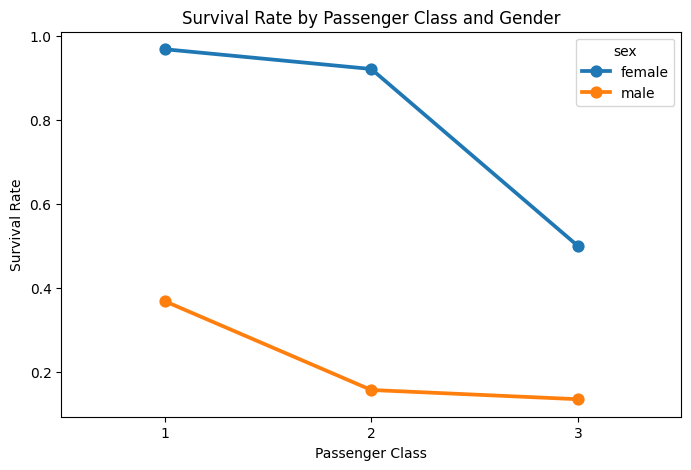

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))

sns.pointplot(
    data=df,
    x="pclass",
    y="survived",
    hue="sex",
    errorbar=None
)

plt.ylabel("Survival Rate")
plt.xlabel("Passenger Class")
plt.title("Survival Rate by Passenger Class and Gender")

plt.show()


* Yes. The plot makes the class and gender gaps obvious, and shows that women survive more than men in every class while survival declines from 1st to 3rd class.
* The Survival strongly depends on both passenger class and gender. Women consistently have higher survival rates than men across all classes. Additionally, survival declines from first to third class. The effect of class appears stronger for men, suggesting an interaction between gender and passenger class.


## Part 1 Step 4: Examining Correlations Between Numerical Features

In addition to categorical variables, the Titanic dataset contains several **numerical features** that may be related to survival. Before modeling, it is useful to examine how these numerical features relate both to **each other** and to the **target variable**.

### Instructions

Create a correlation matrix for the following numerical features:

* `age`: The age of the passenger in years.
* `pclass`: The cabin class of the passenger.
* `sibsp`: The number of siblings or spouses traveling with the passenger.
* `parch`: The number of parents or children traveling with the passenger.


Include the target variable `survived` in the correlation matrix.

Visualize the correlations using a heatmap so that both the **strength** and **direction** of correlations are easy to interpret.

---

## Follow-Up Question (Written Response)

Based on the correlation matrix:

* Which numerical features appear most strongly correlated with survival?
* Are there strong correlations **between features themselves** that might indicate redundancy?
* Start to hypothesis, is it possible that these features actually helped **cause** an increase in their survival, or are the effects merely **correlative**? What is the difference between the two?


               age    pclass     sibsp     parch  survived
age       1.000000 -0.369226 -0.308247 -0.189119 -0.077221
pclass   -0.369226  1.000000  0.083081  0.018443 -0.338481
sibsp    -0.308247  0.083081  1.000000  0.414838 -0.035322
parch    -0.189119  0.018443  0.414838  1.000000  0.081629
survived -0.077221 -0.338481 -0.035322  0.081629  1.000000


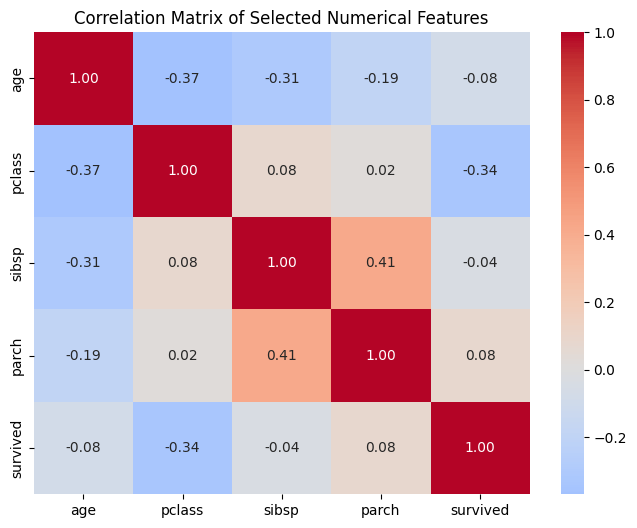

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

cols = ["age", "pclass", "sibsp", "parch", "survived"]

corr_matrix = df[cols].corr()

print(corr_matrix)

plt.figure(figsize=(8,6))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    center=0
)

plt.title("Correlation Matrix of Selected Numerical Features")
plt.show()


1. Which numerical features appear most strongly correlated with survival?
* pclass has the strongest correlation with survival (about -0.338). Age, sibsp, and parch have weak correlations with survival (around -0.08, -0.04, +0.08 respectively).
2. Are there strong correlations between features themselves that might indicate redundancy?
* sibsp and parch are moderately correlated (~0.415), indicating partial redundancy (family group size). Other numerical pairs are not strongly correlated.

3. Start to hypothesis, is it possible that these features actually helped cause an increase in their survival, or are the effects merely correlative? What is the difference between the two?
* These results are correlative. Correlation means two variables move together in the data; causation means changing one would directly change the outcome. For example, pclass likely proxies for cabin location, lifeboat access, or evacuation priority rather than directly causing survival.


## Part 1 Step 5: Exploratory Data Analysis through qualitative evidence

Now your basic exploratory phase is over, and you must find a way to summarize this dataset to your boss, who designs 1800 style boats for daredevil passengers. Your goal is to form a predictive model -- but at this step you are not modeling, only deciding which features are important and why. Scan through each feature

* `pclass`: Passenger class (1 = first class, 2 = second class, 3 = third class)
* `sex`: Passenger sex
* `age`: Passenger age in years
* `sibsp`: Number of siblings or spouses traveling with the passenger
* `parch`: Number of parents or children traveling with the passenger
* `fare`: Ticket fare paid by the passenger
* `embarked`: Port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)
* `who`: Passenger category (man, woman, child)
* `adult_male`: Indicator for adult male passengers
* `deck`: Deck level of the cabin (derived from cabin identifier)
* `class`: Textual version of passenger class (First, Second, Third)
* `alone`: Indicator for whether the passenger was traveling alone

and try several different visualization tools and text inspection techniques.

Here are a few plots to pick from:
1. **Scatter plot**
2. **Box plot**
3. **Violin plot**
4. **Histogram**
5. **Bar plot**
6. **Heatmap**
7. **Pair plot (scatter matrix)**


In your report, include at most 3 plots that inform on the usefulness of each feature, as well as a ranked list of the top 5-10 features. Include a justification of your ranking, using **qualitative evidence** (based on visual inspection).



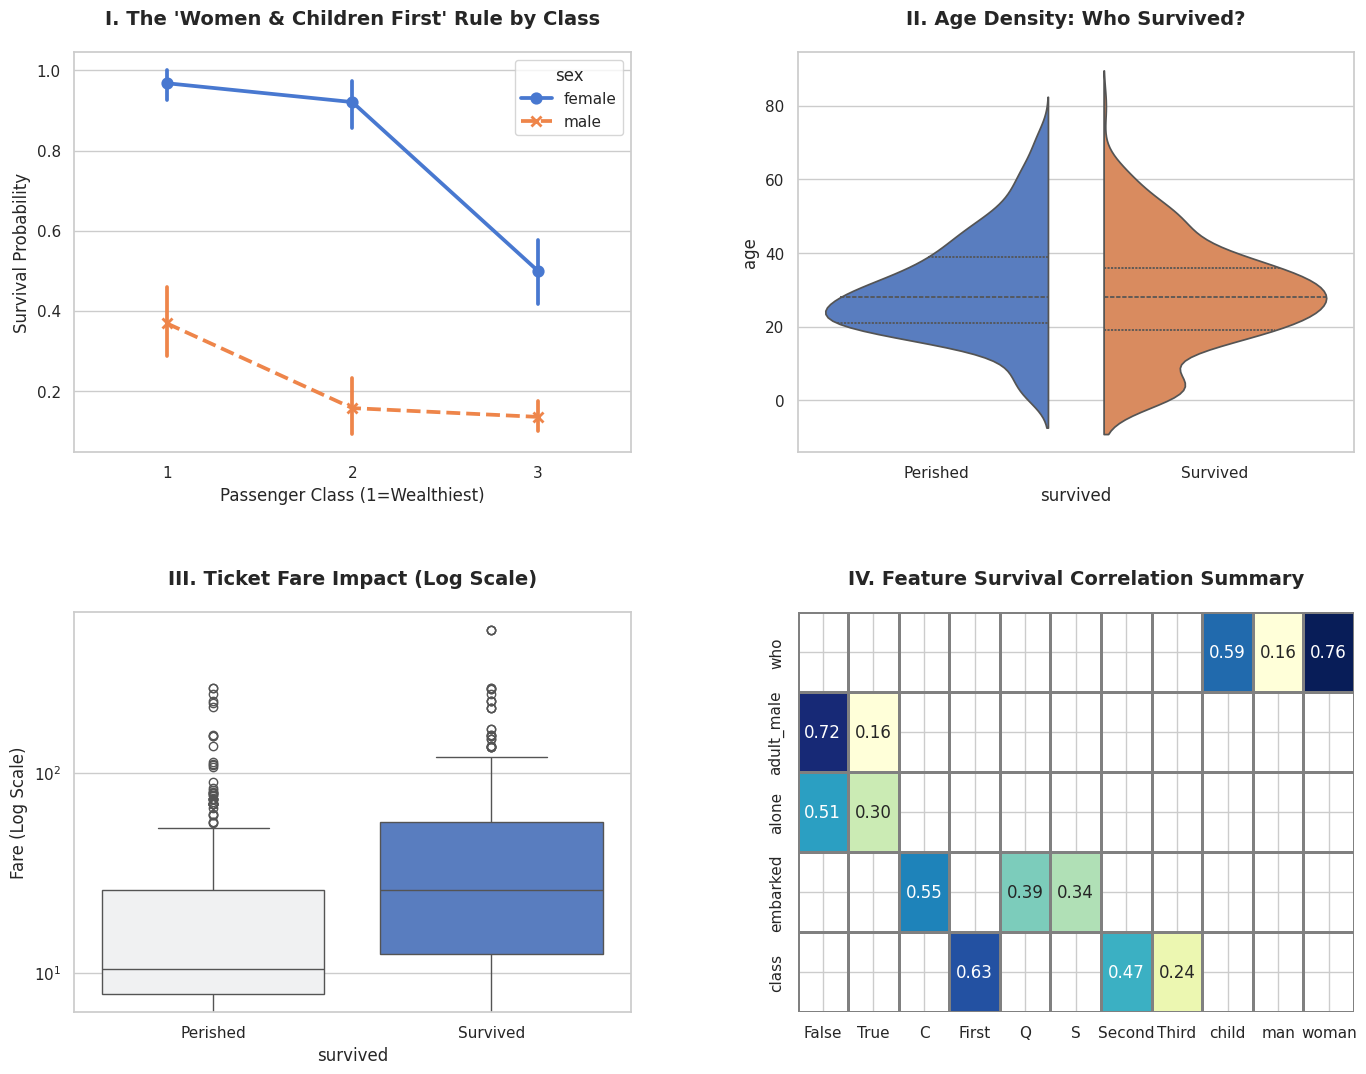

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

df = sns.load_dataset("titanic")
sns.set_theme(style="whitegrid", palette="muted")
fig = plt.figure(figsize=(16, 12))

plt.subplot(2, 2, 1)
sns.pointplot(data=df, x="pclass", y="survived", hue="sex", markers=["o", "x"], linestyles=["-", "--"])
plt.title("I. The 'Women & Children First' Rule by Class", fontsize=14, fontweight='bold', pad=20)
plt.ylabel("Survival Probability")
plt.xlabel("Passenger Class (1=Wealthiest)")

plt.subplot(2, 2, 2)
sns.violinplot(data=df, x="survived", y="age", hue="survived", split=True, inner="quart", legend=False)
plt.title("II. Age Density: Who Survived?", fontsize=14, fontweight='bold', pad=20)
plt.xticks([0, 1], ["Perished", "Survived"])

plt.subplot(2, 2, 3)
sns.boxplot(data=df, x="survived", y="fare", hue="survived", palette="light:b", legend=False)
plt.yscale('log')
plt.title("III. Ticket Fare Impact (Log Scale)", fontsize=14, fontweight='bold', pad=20)
plt.xticks([0, 1], ["Perished", "Survived"])
plt.ylabel("Fare (Log Scale)")

plt.subplot(2, 2, 4)
cat_cols = ["who", "adult_male", "alone", "embarked", "class"]
summary = pd.DataFrame({col: df.groupby(col, observed=True)["survived"].mean() for col in cat_cols}).T

sns.heatmap(summary, annot=True, cmap="YlGnBu", cbar=False, fmt=".2f", linewidths=1, linecolor='gray')
plt.title("IV. Feature Survival Correlation Summary", fontsize=14, fontweight='bold', pad=20)

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.3, hspace=0.4)

plt.show()

## Part 1 Step 6: Exploratory Data Analysis Using Quantitative Evidence

Visual inspection helps build intuition, but quantitative analysis is necessary to make comparisons precise.
In this task, you will analyze feature importance using several quantitative approaches and use the results to reason about **different notions of “importance.”**

---

### One-to-One (Marginal) Correlations

**Task**

Compute the correlation between each individual feature and the target variable (`survived`).

* Compute **Pearson correlation**.
* Compute a **rank-based correlation** (e.g., Spearman).

Rank the features according to each correlation measure.

**Questions**

1. What does it mean for a feature to have a **marginal effect** on the target?
2. What types of relationships are captured by Pearson correlation?
   What additional structure is captured by rank-based correlation?
3. Based on your rankings, which features appear important **marginally**, and which do not?
4. Are there features that appear weak under marginal correlation but may still be useful later?

---

### Many-to-One (Joint) Relationships via Simple Models

**Task**

Choose **one simple model**:

* logistic regression,
* k-nearest neighbors (KNN), or
* decision tree.

Using this model:

* Fit models using **subsets of at most three features**.
* Identify which features or feature combinations lead to the strongest predictive performance.

Report the resulting feature rankings or best-performing subsets.

**Questions**

1. What does it mean for features to have a **joint effect** on the target?
2. How does this approach differ conceptually from one-to-one correlation?
3. Do any features become important only when combined with others?
4. How does your chosen model influence what “joint importance” means?

---

### Leave-One-Out Feature Importance

**Task**

Using the **same model** as in Part 2:

* Fit a model using **all available features**.
* Remove one feature at a time and re-evaluate performance.
* Use the performance change to assign an importance score to each feature.

Rank the features based on this leave-one-out analysis.

**Questions**

1. What does this procedure measure that marginal correlation does not?
2. Is this notion of importance **model-dependent** or **model-agnostic**? Why?
3. Are there features whose importance changes substantially depending on the model?

---


### Reporting Requirements

* Present **three feature-ranking tables**, one for each part.
* Each table must include a caption explaining:

  * what the ranking measures,
  * what notion of importance it reflects,
  * and what its limitations are.


Using your results from all three parts, answer the following:

1. **Marginal vs Joint Effects**
   How do your rankings differ between one-to-one correlations and multi-feature models?
   Give at least one example where the distinction matters.

2. **Correlation vs Predictiveness**
   Are the most highly correlated features always the most predictive?
   Use your results to justify your answer.

3. **Model-Dependent vs Model-Agnostic Interpretations**
   Which of your analyses depend on the choice of model, and which do not?
   How does this affect how much you trust each ranking?

Support your answers by explicitly referencing the tables you produced.



In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns

from itertools import combinations
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

pd.set_option("display.float_format", lambda x: f"{x:.4f}")

df = sns.load_dataset("titanic").dropna(subset=["survived"]).copy()
y = df["survived"].astype(int)
X = df.drop(columns=["survived"]).copy()

if "alive" in X.columns:
    X = X.drop(columns=["alive"])

for c in X.columns:
    if pd.api.types.is_bool_dtype(X[c]):
        X[c] = X[c].fillna(X[c].mode(dropna=True).iloc[0]).astype(int)
    elif pd.api.types.is_numeric_dtype(X[c]):
        X[c] = X[c].fillna(X[c].median())
    else:
        X[c] = X[c].astype(object)
        X[c] = X[c].where(~pd.isna(X[c]), "missing").astype(str)

X_enc = pd.get_dummies(X, drop_first=False).astype(float)

feat_to_cols = {f: [c for c in X_enc.columns if c == f or c.startswith(f + "_")] for f in X.columns}
features = list(feat_to_cols.keys())

# ---------------- Part 1 ----------------
pearson = X_enc.corrwith(y, method="pearson").fillna(0.0)
spearman = X_enc.corrwith(y, method="spearman").fillna(0.0)

rows = []
for f in features:
    cols = feat_to_cols[f]
    p = pearson[cols]; s = spearman[cols]
    rows.append([f, float(p[p.abs().idxmax()]), float(s[s.abs().idxmax()])])

part1 = pd.DataFrame(rows, columns=["feature", "pearson_r", "spearman_r"])
part1["abs_pearson"] = part1["pearson_r"].abs()
part1["abs_spearman"] = part1["spearman_r"].abs()

print("Part 1 - Pearson ranking")
print(part1.sort_values("abs_pearson", ascending=False)[["feature","pearson_r"]].to_string(index=False))

print("\nPart 1 - Spearman ranking")
print(part1.sort_values("abs_spearman", ascending=False)[["feature","spearman_r"]].to_string(index=False))

# ---------------- Parts 2 + 3 ----------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
model = Pipeline([("scaler", StandardScaler()),
                  ("clf", LogisticRegression(max_iter=3000, solver="liblinear"))])

def cv_acc(cols):
    scores = cross_val_score(model, X_enc[cols], y, cv=cv, scoring="accuracy")
    return float(scores.mean()), float(scores.std())

# Part 2: best subsets <= 3
subset_rows = []
for k in [1,2,3]:
    for subset in combinations(features, k):
        cols = []
        for f in subset: cols += feat_to_cols[f]
        cols = list(dict.fromkeys(cols))
        m, s = cv_acc(cols)
        subset_rows.append([k, ", ".join(subset), m, s])

part2 = pd.DataFrame(subset_rows, columns=["k","features","cv_acc_mean","cv_acc_std"])
part2 = part2.sort_values(["cv_acc_mean","k"], ascending=[False,True]).reset_index(drop=True)

print("\nPart 2 - best subsets (top 20)")
print(part2.head(20).to_string(index=False))

# Part 3: leave-one-out
all_cols = list(X_enc.columns)
baseline, _ = cv_acc(all_cols)

loo_rows = []
for f in features:
    keep_cols = [c for c in all_cols if c not in set(feat_to_cols[f])]
    m, _ = cv_acc(keep_cols)
    loo_rows.append([f, baseline, m, baseline - m])

part3 = pd.DataFrame(loo_rows, columns=["feature","baseline_cv_acc","cv_acc_without","importance_drop"])
part3 = part3.sort_values("importance_drop", ascending=False).reset_index(drop=True)

print("\nPart 3 - leave-one-out importance")
print(part3.to_string(index=False))


Part 1 - Pearson ranking
    feature  pearson_r
        who    -0.5571
 adult_male    -0.5571
        sex     0.5434
     pclass    -0.3385
      class    -0.3223
       deck    -0.3196
       fare     0.2573
      alone    -0.2034
   embarked     0.1682
embark_town     0.1682
      parch     0.0816
        age    -0.0649
      sibsp    -0.0353

Part 1 - Spearman ranking
    feature  spearman_r
        who     -0.5571
 adult_male     -0.5571
        sex      0.5434
     pclass     -0.3397
       fare      0.3237
      class     -0.3223
       deck     -0.3196
      alone     -0.2034
   embarked      0.1682
embark_town      0.1682
      parch      0.1383
      sibsp      0.0889
        age     -0.0370

Part 2 - best subsets (top 20)
 k                       features  cv_acc_mean  cv_acc_std
 3             pclass, sibsp, who       0.8204      0.0169
 3              sibsp, class, who       0.8204      0.0169
 3      pclass, sibsp, adult_male       0.8193      0.0174
 3       sibsp, class,

**One to One**

Q. What does it mean for a feature to have a marginal effect on the target?
*  A marginal effect indicates that the feature demonstrates an association with survival when evaluated independently (one-feature-at-a-time), without controlling for or considering the impact of other variables.

Q. What types of relationships are captured by Pearson correlation? What additional structure is captured by rank-based correlation?
* A. Pearson correlation specifically captures linear relationships (associations that follow a straight line). In contrast, Spearman (rank-based) correlation captures monotonic relationships using data ranks, identifying consistently increasing or decreasing trends even if they are non-linear.

Q. Based on your rankings, which features appear important marginally, and which do not?
* Strong marginal (top): who, adult_male, sex.
   Moderate marginal: pclass, class, deck, fare.
   Weak-to-mild marginal: alone, embarked, embark_town.
   Very weak marginal: parch, age, sibsp.

Q. Are there features that appear weak under marginal correlation but may still be useful later?
* Yes. Some features may be useful jointly with others:
   - age: weak marginally, but can matter with sex and class (e.g., children in different classes).
   - sibsp + parch: weak alone, but together capture family/group context.
   - embarked / embark_town: may add value after controlling for class/fare by reflecting different passenger mixes by port.

**Many to One:**

Q. What does it mean for features to have a joint effect on the target?
* A joint effect occurs when the combination of two or more features provides predictive information that is not visible when examining them individually. It implies interaction between variables. For example, knowing a passenger is in "3rd class" becomes more informative when combined with "sex" or "age" (e.g., the "Women and Children First" rule).

Q. How does this approach differ conceptually from one-to-one correlation?
* One-to-one correlation measures the marginal relationship between a single feature and survival, ignoring other variables.
   The subset approach evaluates joint importance. It captures how features work together, identifying:
   - Redundancy: when two features convey similar information.
   - Synergy: when features together provide stronger predictive power than individually.

Q. Do any features become important only when combined with others?
* Yes. In marginal rankings, sibsp and pclass were relatively weak compared to adult_male. However, in subset analysis, sibsp and pclass appear in many top-performing combinations. While sibsp alone is weak, it becomes important when combined with who or pclass, likely because family size affected survival differently across social classes.

Q. How does your chosen model influence what “joint importance” means?
* Using Logistic Regression, joint importance is defined by linearity and additivity. The model assumes the log-odds of survival is a weighted sum of features. Thus, joint importance means features provide distinct, additive evidence that shifts survival probability.
* If a Decision Tree were used instead, joint importance would reflect conditional logic (e.g., survival patterns differ by class, then age matters differently within each class).

**Leave One Out:**

Q. What does this procedure measure that marginal correlation does not?
* Marginal correlation measures how much information a feature carries about the target on its own.
   Leave-One-Out importance measures redundancy and complementarity. It shows how much unique information a feature provides beyond what is already captured by other features in the model.
   For example, if sex and adult_male contain similar information, removing one may not reduce performance (0.0000 change) because the other compensates for it.

Q. Is this notion of importance model-dependent or model-agnostic? Why?
* This procedure is model-dependent. The importance score depends on how a specific algorithm (e.g., Logistic Regression) uses the data.
   A feature may be highly important for a Decision Tree (due to conditional splits) but have low or zero importance in Logistic Regression if the relationship is non-linear and the model cannot capture it.

Q. Are there features whose importance changes substantially depending on the model?
* Yes. In Logistic Regression, fare and age show a negative importance drop (-0.0045 to -0.0056), meaning performance slightly improves when they are removed. This can happen in linear models if a feature is noisy or non-linear.
  * However, in models like K-Nearest Neighbors (KNN) or Random Forest, these features may show strong positive importance because those models better capture complex, non-linear survival patterns related to age and wealth.


# Part 2: Simple classification baselines

Before performing any feature engineering or sophisticated imputation, we will first
establish **baseline performance** using a small collection of standard classifiers.

The goal of this section is **not** to optimize performance, but to understand how
*difficult* this classification task is using the features in their current form.

Using the features as provided:

- Split the data into **training and test sets**.
- Train each of the following models on the training set:
  1. Logistic regression  
  2. Decision tree  
  3. k-Nearest Neighbors (KNN)  
  4. Two-layer MLP with width 8  
  5. Random forest  

- Evaluate each model on the **test set** and report the **test accuracy**.

- For models that **natively provide feature importance** (logistic regression, decision tree, random forest), also report and briefly interpret the **most influential features**.  This is a pretty strong hint for us to know which features are best.




In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier


df_model = df.copy()

# Encode categoricals
df_model["sex"] = df_model["sex"].map({"male": 0, "female": 1})
df_model["adult_male"] = df_model["adult_male"].astype(int)
df_model["alone"] = df_model["alone"].astype(int)
df_model["embarked"] = df_model["embarked"].map({"S": 0, "C": 1, "Q": 2})
df_model["who"] = df_model["who"].map({"man": 0, "woman": 1, "child": 2})
df_model["class"] = df_model["class"].map({"Third": 3, "Second": 2, "First": 1})

# Encode deck
deck_map = {d: i for i, d in enumerate(sorted(df_model["deck"].dropna().unique()))}
df_model["deck"] = df_model["deck"].map(deck_map)

# Drop rows with missing values
df_model = df_model.dropna()

features = [
    "pclass", "sex", "age", "sibsp", "parch",
    "fare", "embarked", "who", "adult_male",
    "deck", "class", "alone"
]

X = df_model[features]
y = df_model["survived"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale for models that need it
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "KNN": KNeighborsClassifier(),
    "MLP (2-layer, width=8)": MLPClassifier(hidden_layer_sizes=(8,8), max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42)
}

results = {}

for name, model in models.items():

    if name in ["Logistic Regression", "KNN", "MLP (2-layer, width=8)"]:
        model.fit(X_train_scaled, y_train)
        preds = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        preds = model.predict(X_test)

    acc = accuracy_score(y_test, preds)
    results[name] = acc

print("Test Accuracies:")
for k, v in results.items():
    print(f"{k}: {v:.4f}")

print("\nLogistic Regression Coefficients:")
log_model = models["Logistic Regression"]
log_importance = pd.Series(
    log_model.coef_[0], index=features
).sort_values(key=abs, ascending=False)
print(log_importance)

print("\nDecision Tree Feature Importance:")
tree_model = models["Decision Tree"]
tree_importance = pd.Series(
    tree_model.feature_importances_, index=features
).sort_values(ascending=False)
print(tree_importance)

print("\nRandom Forest Feature Importance:")
rf_model = models["Random Forest"]
rf_importance = pd.Series(
    rf_model.feature_importances_, index=features
).sort_values(ascending=False)
print(rf_importance)


Test Accuracies:
Logistic Regression: 0.6216
Decision Tree: 0.6486
KNN: 0.5946
MLP (2-layer, width=8): 0.6486
Random Forest: 0.6757

Logistic Regression Coefficients:
adult_male   -1.5373
parch        -0.5746
fare          0.2929
embarked      0.2828
sex           0.2637
deck         -0.2014
alone        -0.0789
age          -0.0680
sibsp        -0.0349
pclass       -0.0274
class        -0.0274
who           0.0273
dtype: float64

Decision Tree Feature Importance:
who          0.3802
age          0.2976
fare         0.1502
deck         0.1033
embarked     0.0414
parch        0.0273
pclass       0.0000
sex          0.0000
sibsp        0.0000
adult_male   0.0000
class        0.0000
alone        0.0000
dtype: float64

Random Forest Feature Importance:
age          0.2191
fare         0.1926
adult_male   0.1444
who          0.1204
sex          0.1024
deck         0.0971
embarked     0.0354
parch        0.0343
sibsp        0.0219
alone        0.0119
pclass       0.0109
class        0.0095
d

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


# Part 3: Missing data

## Missing Data Is Not Uniform

In real datasets, **missing data is rarely random**.
Instead, whether a value is missing often reflects **how the data was collected**, **who was recorded carefully**, and **which groups were less visible**.

In the Titanic dataset, some passenger attributes are missing far more often than others—and crucially, **they are not missing uniformly across passengers**.
Before we decide how to “fix” missing data, we should first **understand its structure**.


---

## Part 3 Step 1: Correlation Between Missingness and Other Features

Rather than immediately imputing missing values, we first ask:

> *When a value is missing, what else about that passenger tends to be different?*


### Instructions

1. Identify the features that contain missing values.
2. For each such feature, create a binary indicator that is `1` if the value is missing and `0` otherwise.
3. Encode categorical variables numerically so that relationships can be compared.
4. Compute the correlation between each missingness indicator and the other features.
5. Summarize the results in a **table** showing how missingness relates to passenger attributes (e.g., class, fare, survival).


Which feature is most correlated with data being missing? Any thoughts as to whether this relationship is a *correlation* or a *causation*? Why? Don't be afraid to guess, as long as you make clear it is a guess, not an evidence-based fact.

In [ ]:
import pandas as pd
import numpy as np

df_missing = df.copy()

missing_features = df_missing.columns[df_missing.isnull().any()]
print("Features with missing values:")
print(missing_features.tolist())

for col in missing_features:
    df_missing[col + "_missing"] = df_missing[col].isnull().astype(int)

df_missing["sex"] = df_missing["sex"].map({"male": 0, "female": 1})
df_missing["adult_male"] = df_missing["adult_male"].astype(int)
df_missing["alone"] = df_missing["alone"].astype(int)
df_missing["embarked"] = df_missing["embarked"].map({"S": 0, "C": 1, "Q": 2})
df_missing["who"] = df_missing["who"].map({"man": 0, "woman": 1, "child": 2})
df_missing["class"] = df_missing["class"].map({"Third": 3, "Second": 2, "First": 1})

deck_map = {d: i for i, d in enumerate(sorted(df_missing["deck"].dropna().unique()))}
df_missing["deck"] = df_missing["deck"].map(deck_map)

numeric_df = df_missing.select_dtypes(include=[np.number])

missing_indicators = [col for col in numeric_df.columns if col.endswith("_missing")]

correlation_table = {}

for indicator in missing_indicators:
    corr = numeric_df.corr()["{}".format(indicator)]
    correlation_table[indicator] = corr

correlation_table = pd.DataFrame(correlation_table)

# Remove self-correlation rows
for col in missing_indicators:
    correlation_table.loc[col, col] = np.nan

print("\nCorrelation Between Missingness Indicators and Other Features:\n")
print(correlation_table.round(3))


Features with missing values:
['age', 'embarked', 'deck', 'embark_town']

Correlation Between Missingness Indicators and Other Features:

                     age_missing  embarked_missing  deck_missing  \
survived                 -0.0920            0.0600       -0.3200   
pclass                    0.1730           -0.0740        0.7230   
sex                      -0.0550            0.0640       -0.1430   
age                          NaN            0.0740       -0.2470   
sibsp                     0.0190           -0.0230        0.0390   
parch                    -0.1240           -0.0220       -0.0380   
fare                     -0.1010            0.0460       -0.4830   
embarked                  0.3190               NaN       -0.0180   
who                      -0.1440            0.0370       -0.0710   
adult_male                0.1000           -0.0580        0.1280   
alone                     0.1510            0.0390        0.1600   
age_missing                  NaN           -0.

1) Which feature is most correlated with missingness?

* The strongest correlation is between deck_missing and pclass (0.723).

* This indicates that deck information is much more likely to be missing for certain passenger classes.

* There is also a notable negative correlation between deck_missing and fare (-0.483), suggesting that passengers who paid lower fares were more likely to have missing deck information.

* Missing deck information is also moderately correlated with survival (-0.320).

2) Is this correlation or causation?

* This is most likely correlation, not causation.

* It is unlikely that being in a certain class directly caused deck information to be missing.

* A more plausible explanation is that deck information was recorded more consistently for higher-class passengers.

* Therefore, missing deck data likely reflects differences in record-keeping or cabin assignment practices rather than a direct causal relationship.

* In summary, deck missingness appears structurally linked to socioeconomic status rather than being random.

## Part 3 Step 2: Data Imputation on Titanic — Deck

The feature `deck` is **mostly missing**, and its missingness is strongly tied to
the socioeconomic structure of the Titanic passengers.


In particular, deck information is closely related to **passenger class (`pclass`)**
(and, to a lesser extent, fare). This makes `deck` a good candidate for
**structured imputation**, rather than arbitrary filling.

### Task

Your goal is to use the observed data to determine how `deck` relates to other features,
and then use that relationship to **impute missing deck values**.

### Instructions
1. Compute a cross-tabulation of `survived` versus `deck`
   to verify that survival rates differ across decks, and that `deck` is therefore
   an informative feature worth imputing.
2. Restrict the dataset to rows where `deck` is **observed**.
3. Treat `deck` as the **prediction target** and use the remaining features as inputs.
4. Fit a logistic regression model to predict `deck`
5. Evaluate and compare the model's performance.
6. For each model, inspect and report **feature importance** (where available).
7. Use a **cross-tabulation** (`pd.crosstab`) between `deck` and the most important feature
   to verify that the learned relationship is reasonable.

### Discussion Question

Based on your analysis:

- How important is `deck` to survivorship?
- Which feature or features most strongly predict a passenger’s deck when deck is observed?
- How do the model results (accuracy and feature importance) support this conclusion?
- Does the relationship you identified make sense when examined directly in the data
  (e.g., via a cross-tabulation)?
- Why does this make the chosen feature(s) appropriate for imputing missing deck values?


Survival rates by deck (normalize by deck):
survived      0      1
deck                  
A        0.5330 0.4670
B        0.2550 0.7450
C        0.4070 0.5930
D        0.2420 0.7580
E        0.2500 0.7500
F        0.3850 0.6150
G        0.5000 0.5000


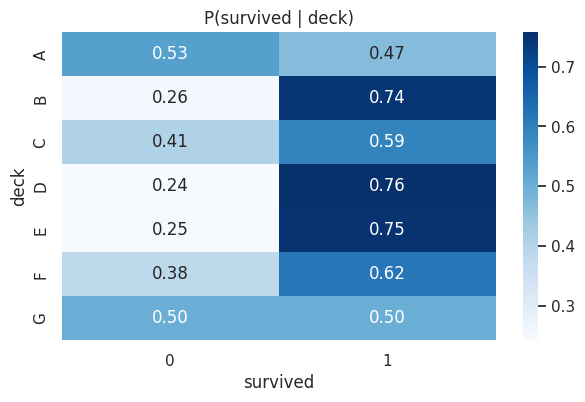


Rows with observed deck: 203
Rows usable for deck-prediction model (after dropping NaNs in inputs): 182

Deck prediction test accuracy: 0.3243

Classification report (deck_code):
              precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           1       0.33      0.11      0.17         9
           2       0.25      0.40      0.31        10
           3       0.00      0.00      0.00         6
           4       0.25      0.50      0.33         6
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         1

    accuracy                           0.32        37
   macro avg       0.55      0.48      0.47        37
weighted avg       0.35      0.32      0.30        37


Most influential features for predicting deck (LogReg, mean |coef| across classes):
fare       0.6162
pclass     0.4730
class      0.4730
sex        0.4237
alone      0.3644
embarked   0.3519
sibsp      0.3250
parch      0

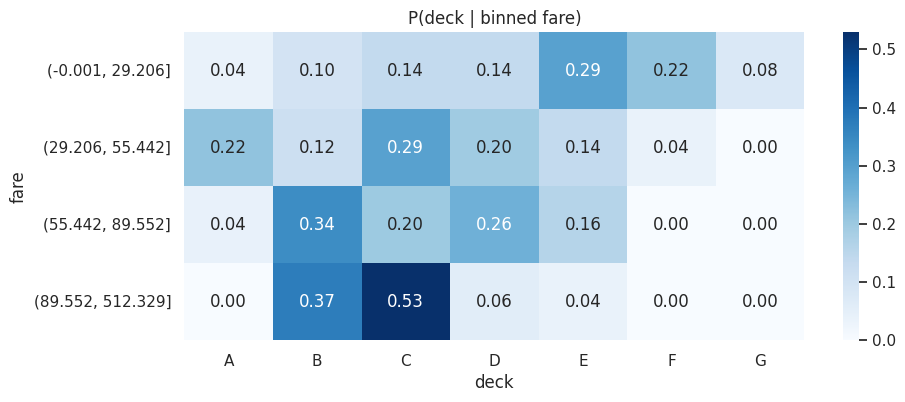

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report


# Cross-tab: survived vs deck
print("Survival rates by deck (normalize by deck):")
deck_survival = pd.crosstab(df["deck"], df["survived"], normalize="index")
print(deck_survival.round(3))

plt.figure(figsize=(7,4))
sns.heatmap(deck_survival, annot=True, cmap="Blues", fmt=".2f")
plt.title("P(survived | deck)")
plt.show()


# Restrict to rows where deck is observed
df_deck = df.dropna(subset=["deck"]).copy()

# Encode inputs (simple numeric encoding)
df_deck["sex"] = df_deck["sex"].map({"male": 0, "female": 1})
df_deck["adult_male"] = df_deck["adult_male"].astype(int)
df_deck["alone"] = df_deck["alone"].astype(int)
df_deck["embarked"] = df_deck["embarked"].map({"S": 0, "C": 1, "Q": 2})
df_deck["who"] = df_deck["who"].map({"man": 0, "woman": 1, "child": 2})
df_deck["class"] = df_deck["class"].map({"Third": 3, "Second": 2, "First": 1})

# Encode deck target as category codes, and store mapping for readability
deck_cat = df_deck["deck"].astype("category")
deck_code_map = dict(enumerate(deck_cat.cat.categories))
df_deck["deck_code"] = deck_cat.cat.codes

features = ["pclass", "sex", "age", "sibsp", "parch", "fare", "embarked", "who", "adult_male", "class", "alone"]
target = "deck_code"

# Logistic regression can't handle NaNs -> drop rows with NaNs in input features
df_deck_model = df_deck[features + [target]].dropna()

print("\nRows with observed deck:", len(df_deck))
print("Rows usable for deck-prediction model (after dropping NaNs in inputs):", len(df_deck_model))

X = df_deck_model[features]
y = df_deck_model[target]

# Fit logistic regression to predict deck
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

log_model = LogisticRegression(max_iter=3000)
log_model.fit(X_train_s, y_train)

y_pred = log_model.predict(X_test_s)

print("\nDeck prediction test accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("\nClassification report (deck_code):")
print(classification_report(y_test, y_pred))


# Feature importance (logistic regression)
coef_importance = np.mean(np.abs(log_model.coef_), axis=0)
importance = pd.Series(coef_importance, index=features).sort_values(ascending=False)

print("\nMost influential features for predicting deck (LogReg, mean |coef| across classes):")
print(importance.head(10).round(4))


# 5) Cross-tab deck vs most important feature
top_feat = importance.index[0]
print(f"\nTop feature according to logistic regression: {top_feat}")

# Show deck distribution by top feature
if top_feat in ["pclass", "class", "embarked", "who", "sex", "adult_male", "alone"]:
    ct = pd.crosstab(df_deck[top_feat], df_deck["deck"], normalize="index")
    print("\nCross-tab (normalize by top feature):")
    print(ct.round(3))

    plt.figure(figsize=(8,4))
    sns.heatmap(ct, annot=True, cmap="Blues", fmt=".2f")
    plt.title(f"P(deck | {top_feat})")
    plt.show()
else:
    # If top feature is continuous, bin it for a crosstab
    binned = pd.qcut(df_deck[top_feat], q=4, duplicates="drop")
    ct = pd.crosstab(binned, df_deck["deck"], normalize="index")
    print("\nCross-tab with binned feature (quartiles):")
    print(ct.round(3))

    plt.figure(figsize=(10,4))
    sns.heatmap(ct, annot=True, cmap="Blues", fmt=".2f")
    plt.title(f"P(deck | binned {top_feat})")
    plt.show()


## Part 3 Step 3: Data Imputation on Titanic — Age

The feature `age` is partially missing and plays a meaningful role in survival.
However, unlike `deck`, age is a **continuous variable**, and its relationship to
other features is more nuanced.

Because age is not categorical, simple cross-tabulations are not sufficient to
understand its role. Instead, we must examine **how the distribution of age varies**
across survival outcomes and passenger groups.

### Task

Your goal is to understand how age relates to survival, sex, and passenger class,
and to assess whether age can be reliably inferred from other observed features.

### Instructions

1. Examine how the distribution of age varies with survival status.
2. To control for major confounders, stratify the age distributions by:
   - passenger class (`pclass`)
   - sex
3. Use a **faceted histogram** to visualize age distributions across these groups,
   with survival status indicated separately.
4. Restrict the dataset to rows where `age` is observed.
5. Treat `age` as a **regression target** and use the remaining features as inputs.
6. Fit the following regression models to predict age:
   - Linear regression  
   - Decision tree regressor  
   - k-Nearest Neighbors regressor  
7. Evaluate each model using an appropriate regression metric (e.g., RMSE).
8. Based on both the visualizations and the regression results, assess whether age
   is strongly predictable from the available features.

### Discussion Question

Based on your analysis:

- How does age affect survival, and how does this effect differ across sex and passenger class?
- How well can age be predicted from the other observed features? Can prediction be a reliable impotation strategy in this case?



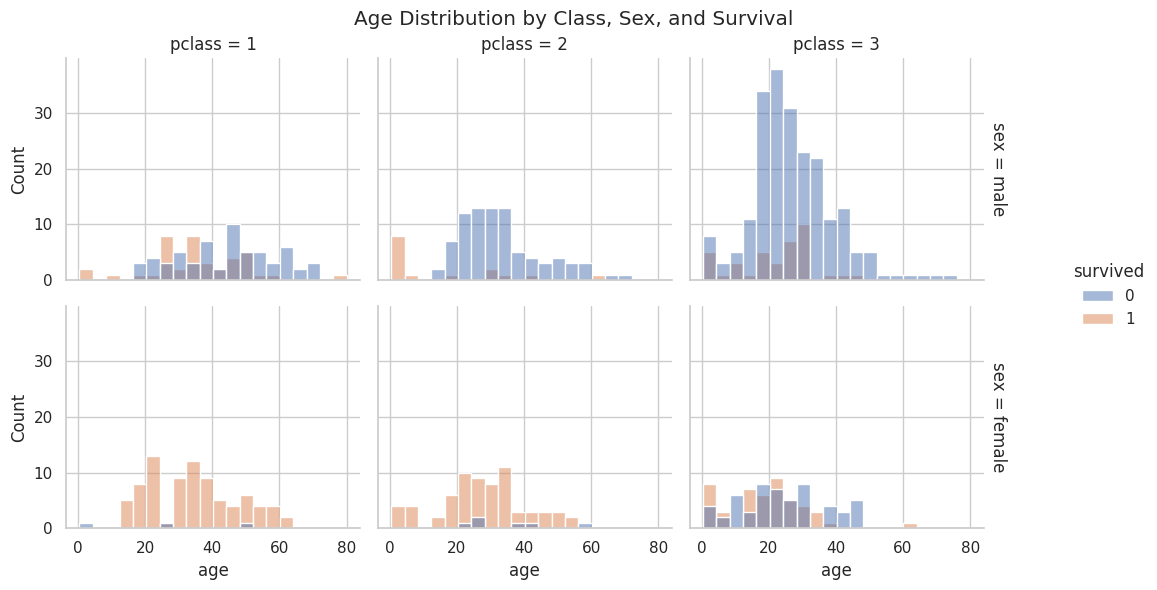

Age Prediction RMSE:

Linear Regression: 13.49
Decision Tree: 13.89
KNN: 15.42


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

sns.set_theme(style="whitegrid")

# Visualize Age Distribution (Faceted Histogram)
g = sns.displot(
    data=df,
    x="age",
    col="pclass",
    row="sex",
    hue="survived",
    kind="hist",
    bins=20,
    height=3,
    aspect=1.2,
    facet_kws={"margin_titles": True}
)

g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Age Distribution by Class, Sex, and Survival")
plt.show()


# Predict Age Using Regression

# Restrict to rows where age is observed
df_age = df.dropna(subset=["age"]).copy()

# Encode categorical variables
df_age["sex"] = df_age["sex"].map({"male": 0, "female": 1})
df_age["adult_male"] = df_age["adult_male"].astype(int)
df_age["alone"] = df_age["alone"].astype(int)
df_age["embarked"] = df_age["embarked"].map({"S": 0, "C": 1, "Q": 2})
df_age["who"] = df_age["who"].map({"man": 0, "woman": 1, "child": 2})
df_age["class"] = df_age["class"].map({"Third": 3, "Second": 2, "First": 1})

deck_map = {d: i for i, d in enumerate(sorted(df_age["deck"].dropna().unique()))}
df_age["deck"] = df_age["deck"].map(deck_map)

# Select features
features = [
    "pclass", "sex", "sibsp", "parch",
    "fare", "embarked", "who",
    "adult_male", "deck", "class", "alone"
]

df_age_model = df_age[features + ["age"]].dropna()

X = df_age_model[features]
y = df_age_model["age"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale for linear + KNN
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# Models
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "KNN": KNeighborsRegressor()
}

print("Age Prediction RMSE:\n")

for name, model in models.items():

    if name in ["Linear Regression", "KNN"]:
        model.fit(X_train_s, y_train)
        preds = model.predict(X_test_s)
    else:
        model.fit(X_train, y_train)
        preds = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, preds))
    print(f"{name}: {rmse:.2f}")


1) Based on both the visualizations and the regression results, assess whether age is strongly predictable from the available features.

* Age distributions differ somewhat across passenger class and sex.

* Children appear more concentrated in certain groups.

* However, there is substantial overlap in age distributions across survival outcomes.

* Regression RMSE values (13–15 years) are close to the overall standard deviation of age (14 years).

* None of the models significantly outperform a simple mean prediction baseline.

## Part 3 Step 4: Imputation and Model Comparison

For both `deck` and `age`, select one or more imputation strategies, apply them to
the dataset, and compare model performance **with and without imputation**.

### Instructions

1. For each of `deck` and `age`, choose at least one imputation strategy from the
   following options (or propose a reasonable alternative):
   - Predict the missing value using a trained model  
   - Fill with the **median** or **mean** of the observed values  
   - Fill with a **hard-coded value** (e.g., based on passenger class, or a fixed constant that you can justify)
2. Briefly justify your choice of imputation strategy for each feature.
3. Create two versions of the dataset:
   - one **without imputation** (using the original missing values)
   - one **with imputed values**
4. Using each dataset version, train and evaluate the following classifiers:
   1. Logistic regression  
   2. Decision tree  
   3. k-Nearest Neighbors (KNN)  
   4. Two-layer MLP with width 8  
   5. Random forest  
5. Report and compare the **test accuracy** across models and across dataset versions.
6. Assess whether imputation improves, degrades, or has little effect on performance.

### Discussion Questions

After comparing model performance across the different imputation strategies, answer the following:

- Did any imputation strategy **clearly improve** performance relative to no imputation?
  Did any strategy **hurt** performance?
- Were the performance differences **consistent across models**, or did some models
  benefit while others did not?
- Given that the accuracy differences are small, are they **large enough to be meaningful**,
  or could they plausibly be due to random variation from the train–test split?
- Why might a structured imputation strategy help for `deck` but have little effect—or even
  a negative effect—for `age`?
- In what situations is it preferable to **leave missing values untreated** rather than
  impute them, even if a reasonable imputation strategy is available?


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

df_base = df.copy()

# Encode categoricals
df_base["sex"] = df_base["sex"].map({"male": 0, "female": 1})
df_base["adult_male"] = df_base["adult_male"].astype(int)
df_base["alone"] = df_base["alone"].astype(int)
df_base["embarked"] = df_base["embarked"].map({"S": 0, "C": 1, "Q": 2})
df_base["who"] = df_base["who"].map({"man": 0, "woman": 1, "child": 2})
df_base["class"] = df_base["class"].map({"Third": 3, "Second": 2, "First": 1})

deck_map = {d: i for i, d in enumerate(sorted(df_base["deck"].dropna().unique()))}
df_base["deck"] = df_base["deck"].map(deck_map)

features = [
    "pclass", "sex", "age", "sibsp", "parch",
    "fare", "embarked", "who",
    "adult_male", "deck", "class", "alone"
]

# DATASET VERSION 1: No Imputation (Drop Missing)

df_no_imp = df_base[features + ["survived"]].dropna()
print(df_no_imp.shape)

X1 = df_no_imp[features]
y1 = df_no_imp["survived"]

X1_train, X1_test, y1_train, y1_test = train_test_split(
    X1, y1, test_size=0.2, random_state=42
)

scaler1 = StandardScaler()
X1_train_s = scaler1.fit_transform(X1_train)
X1_test_s = scaler1.transform(X1_test)

# DATASET VERSION 2: With Imputation
# Strategy:
# - Age → median
# - Deck → fill with most common deck per class

df_imp = df_base.copy()

# Age imputation (median)
df_imp["age"] = df_imp["age"].fillna(df_imp["age"].median())

# Deck imputation (mode within passenger class)
for c in df_imp["class"].unique():
    mode_deck = df_imp.loc[
        (df_imp["class"] == c) & (df_imp["deck"].notna()),
        "deck"
    ].mode()

    if not mode_deck.empty:
        df_imp.loc[
            (df_imp["class"] == c) & (df_imp["deck"].isna()),
            "deck"
        ] = mode_deck.iloc[0]

df_imp = df_imp.dropna()

X2 = df_imp[features]
y2 = df_imp["survived"]

X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y2, test_size=0.2, random_state=42
)

scaler2 = StandardScaler()
X2_train_s = scaler2.fit_transform(X2_train)
X2_test_s = scaler2.transform(X2_test)

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "KNN": KNeighborsClassifier(),
    "MLP": MLPClassifier(hidden_layer_sizes=(8,8), max_iter=3000, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42)
}

print("=== Test Accuracy Comparison ===\n")

for name, model in models.items():

    # Version 1
    if name in ["Logistic Regression", "KNN", "MLP"]:
        model.fit(X1_train_s, y1_train)
        preds1 = model.predict(X1_test_s)
    else:
        model.fit(X1_train, y1_train)
        preds1 = model.predict(X1_test)

    acc1 = accuracy_score(y1_test, preds1)

    # Version 2
    if name in ["Logistic Regression", "KNN", "MLP"]:
        model.fit(X2_train_s, y2_train)
        preds2 = model.predict(X2_test_s)
    else:
        model.fit(X2_train, y2_train)
        preds2 = model.predict(X2_test)

    acc2 = accuracy_score(y2_test, preds2)

    print(f"{name}:")
    print(f"   No Imputation: {acc1:.4f}")
    print(f"   With Imputation: {acc2:.4f}\n")


(182, 13)
=== Test Accuracy Comparison ===

Logistic Regression:
   No Imputation: 0.6216
   With Imputation: 0.8258

Decision Tree:
   No Imputation: 0.6486
   With Imputation: 0.7416

KNN:
   No Imputation: 0.5946
   With Imputation: 0.7528

MLP:
   No Imputation: 0.7297
   With Imputation: 0.8090

Random Forest:
   No Imputation: 0.6757
   With Imputation: 0.7584

